In [1]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import KMeansSMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import warnings
warnings.filterwarnings("ignore")

In [ ]:
class_train = pd.read_csv("train_class.csv") # 3 лаба
class_test = pd.read_csv("test_class.csv")

regression_train = pd.read_csv("train_reg.csv") # 4 лаба
regression_test = pd.read_csv("test_reg.csv")

# Предварительная обработка данных для классификации 

In [ ]:
# Определяем списки категориальных и числовых признаков
class_cat = ["Gender", "Vehicle_Age", "Vehicle_Damage"]  # Категориальные признаки
class_num = ["Age", "Driving_License", "Previously_Insured", "Region_Code", 
             "Annual_Premium", "Policy_Sales_Channel", "Vintage"]  # Числовые признаки

# Объединяем все признаки в один список
class_all = class_num + class_cat

# Целевая переменная
class_result = "Response"

# Удаляем столбец 'id' из тренировочного и тестового наборов данных
class_train.drop("id", axis=1, inplace=True)  # Удаление столбца id из тренировочных данных
class_test.drop("id", axis=1, inplace=True)   # Удаление столбца id из тестовых данных

# Инициализируем LabelEncoder для преобразования категориальных признаков
le = LabelEncoder()

# Обрабатываем категориальные признаки:
for column in class_cat:
    # Преобразуем категориальные признаки в числовые с помощью LabelEncoder
    class_train[column] = le.fit_transform(class_train[column])  # Применение к тренировочным данным
    class_test[column] = le.fit_transform(class_test[column])   # Применение к тестовым данным
    
    # Преобразуем тип данных в категориальный
    class_train[column] = class_train[column].astype("category")  # Для тренировочных данных
    class_test[column] = class_test[column].astype("category")   # Для тестовых данных

# Инициализируем MinMaxScaler для нормализации числовых признаков
scaler = MinMaxScaler()

# Нормализуем числовые признаки в диапазоне [0, 1]
class_train[class_num] = scaler.fit_transform(class_train[class_num])  # Для тренировочных данных
class_test[class_num] = scaler.fit_transform(class_test[class_num])   # Для тестовых данных

# Выводим информацию о тренировочном наборе данных
class_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229292 entries, 0 to 229291
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Gender                229292 non-null  category
 1   Age                   229292 non-null  float64 
 2   Driving_License       229292 non-null  float64 
 3   Region_Code           229292 non-null  float64 
 4   Previously_Insured    229292 non-null  float64 
 5   Vehicle_Age           229292 non-null  category
 6   Vehicle_Damage        229292 non-null  category
 7   Annual_Premium        229292 non-null  float64 
 8   Policy_Sales_Channel  229292 non-null  float64 
 9   Vintage               229292 non-null  float64 
 10  Response              229292 non-null  int64   
dtypes: category(3), float64(7), int64(1)
memory usage: 14.7 MB


# Предварительная обработка для регрессии

In [4]:
# Определяем название столбца с целевой переменной (регрессия)
regression_result = 'Цена'  # Название целевой переменной (зависимая переменная)

# Удаляем столбец 'id' из тренировочного и тестового наборов данных
regression_train.drop("id", axis=1, inplace=True)  # Удаляем ненужный столбец из обучающей выборки
regression_test.drop("id", axis=1, inplace=True)   # Удаляем ненужный столбец из тестовой выборки

# Разделение признаков на числовые и категориальные
regression_num = []  # Список для числовых признаков
regression_cat = []  # Список для категориальных признаков

# Автоматическое разделение признаков по типу:
for name in regression_train.columns:
    if regression_train[name].nunique() > 5:  # Если уникальных значений больше 5 - считаем числовым
        regression_num.append(name)
    else:                                    # Иначе - категориальным
        regression_cat.append(name)

# Удаляем целевую переменную из списка числовых признаков (если она там есть)
regression_num.remove(regression_result)  # Исключаем целевую переменную из признаков

# Создаем объединенный список всех признаков
regression_all = regression_num + regression_cat  # Все признаки для моделирования

# Нормализация числовых признаков с помощью MinMaxScaler (приведение к диапазону [0, 1])
scaler = MinMaxScaler()  # Инициализация нормализатора

# Применяем нормализацию к данным
regression_train[regression_num] = scaler.fit_transform(regression_train[regression_num])  # Обучающая выборка
regression_test[regression_num] = scaler.fit_transform(regression_test[regression_num])    # Тестовая выборка

# Выводим информацию о структуре тренировочного набора данных
regression_train.info()  # Просмотр информации о типах данных и наличии пропусков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Количество.комнат          808 non-null    int64  
 1   Студия                     808 non-null    int64  
 2   Общая.площадь              808 non-null    float64
 3   Этаж                       808 non-null    float64
 4   Этажей.в.доме              808 non-null    float64
 5   Парковка                   808 non-null    int64  
 6   Без.ремонта                808 non-null    int64  
 7   Дизайнерский               808 non-null    int64  
 8   Евроремонт                 808 non-null    int64  
 9   Косметический              808 non-null    int64  
 10  Балкон                     808 non-null    int64  
 11  Лоджия                     808 non-null    int64  
 12  Совмещенный.санузел        808 non-null    int64  
 13  Раздельный.санузел         808 non-null    int64  

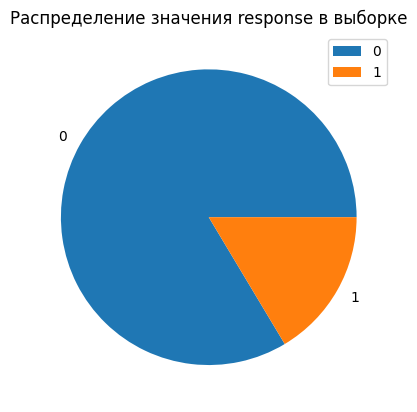

In [5]:
plt.pie(class_train[class_result].value_counts(), labels=(0, 1))
plt.title("Распределение значения response в выборке")
plt.legend((0, 1))
plt.show()

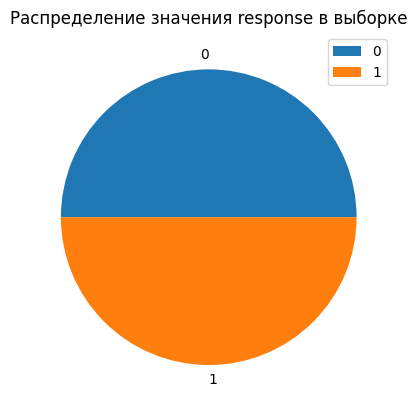

In [6]:
# Выделяем признаки (X) и целевую переменную (y) из обучающего набора данных
x = class_train[class_all]  # Матрица признаков (все независимые переменные)
y = class_train[class_result]  # Вектор целевой переменной (зависимая переменная)

# Применяем KMeansSMOTE для устранения дисбаланса классов:
# - cluster_balance_threshold=0.3 - параметр, определяющий порог балансировки кластеров
# - метод сначала группирует данные в кластеры с помощью K-means
# - затем применяет SMOTE (Synthetic Minority Oversampling Technique) для генерации синтетических примеров меньшего класса
x, y = KMeansSMOTE(cluster_balance_threshold=0.3).fit_resample(x, y)

# Визуализируем распределение классов после балансировки:
plt.pie(y.value_counts(),  # Количество элементов каждого класса
        labels=(0, 1))    # Метки классов (0 и 1)

# Настраиваем отображение графика:
plt.title("Распределение значения response в выборке")  # Заголовок
plt.legend((0, 1))  # Легенда с обозначением классов
plt.show()  # Отображение графика

In [7]:
# Разделение данных для задачи классификации:
# x - матрица признаков после балансировки (KMeansSMOTE)
# y - соответствующие целевые значения (сбалансированные)
# test_size=0.3 - 30% данных уходит в тестовую выборку
# random_state=7 - фиксируем случайное состояние для воспроизводимости результатов
x_train_class, x_test_class, y_train_class, y_test_class = train_test_split(
    x, y, 
    test_size=0.3, 
    random_state=7
)

# Подготовка данных для задачи регрессии:
# Выделяем признаки (x) и целевую переменную (y) из датасета регрессии
x = regression_train[regression_all]  # Все независимые переменные
y = regression_train[regression_result]  # Зависимая переменная ('Цена')

# Разделение данных для задачи регрессии:
# Аналогичные параметры (test_size=0.3, random_state=7) для согласованности
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(
    x, y, 
    test_size=0.3, 
    random_state=7
)

In [ ]:
def compare_parameters(parameters, test_scores, train_scores, is_regression=False):
    """
    Визуализирует сравнение метрик качества для разных параметров модели.
    
    Args:
        parameters (dict): Словарь с параметрами и их значениями
        test_scores (dict): Результаты на тестовой выборке
        train_scores (dict): Результаты на тренировочной выборке
        is_regression (bool): Флаг задачи регрессии (False для классификации)
    """
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))  # Создаем 3 подграфика
    fig.subplots_adjust(hspace=0.4)  # Настраиваем отступы
    id = 0  # Счетчик для подграфиков
    
    for key in test_scores.keys():
        if key != "criterion":
            # Для обычных параметров строим линейные графики
            plot_accuracy_graph(parameters[key], key, axs[id], train_scores[key], 
                              test_scores[key], regression=is_regression)
        else:
            # Для критериев строим столбчатую диаграмму
            plot_criteria(parameters[key], axs[id], train_scores[key], 
                         test_scores[key], regression=is_regression)
        id += 1

def create_best_model(params, is_regression=False):
    """
    Создает и обучает модель с оптимальными параметрами.
    
    Args:
        params (dict): Оптимальные параметры модели
        is_regression (bool): Флаг задачи регрессии
    
    Returns:
        tuple: (обученная модель, оценка качества)
    """
    # Выбираем класс модели в зависимости от типа задачи
    model_class = DecisionTreeRegressor if is_regression else DecisionTreeClassifier
    model = model_class(**params)  # Создаем модель с заданными параметрами
    
    # Обучаем на соответствующих данных
    model.fit(x_train_reg if is_regression else x_train_class,
              y_train_reg if is_regression else y_train_class)
    
    # Оцениваем качество на тестовых данных
    score = model.score(x_test_reg if is_regression else x_test_class,
                        y_test_reg if is_regression else y_test_class)
    
    print(f"Model: {model}\nScore: {round(score, 3)}")
    return model, score

def build_grid(params, x_train, y_train, x_test, y_test, is_regression):
    """
    Выполняет поиск по сетке параметров с кросс-валидацией.
    
    Args:
        params (dict): Сетка параметров для поиска
        x_train, y_train: Тренировочные данные
        x_test, y_test: Тестовые данные
        is_regression (bool): Флаг задачи регрессии
    
    Returns:
        tuple: (результаты кросс-валидации, лучшие параметры)
    """
    model_class = DecisionTreeRegressor if is_regression else DecisionTreeClassifier
    # Выбираем метрику в зависимости от типа задачи
    scoring = 'neg_mean_squared_error' if is_regression else 'roc_auc'
    
    # Настраиваем поиск по сетке
    grid = GridSearchCV(model_class(), params, scoring=scoring)
    grid.fit(x_train, y_train)
    
    # Для регрессии используем R^2 score на тестовых данных
    score = grid.best_score_ if not is_regression else r2_score(y_test, grid.predict(x_test))
    
    print(f"The best model: {grid.best_estimator_}\nAccuracy: {round(score, 3)}")
    return grid.cv_results_["mean_test_score"], grid.best_params_

def test_parameters(parameters, train_acc, test_acc, cross_val_acc, x_train, y_train, x_test, y_test, is_regression=False):
    """
    Тестирует различные значения параметра и сохраняет результаты.
    
    Args:
        parameters (dict): Параметры и их значения для тестирования
        train_acc (dict): Для сохранения результатов на тренировочных данных
        test_acc (dict): Для сохранения результатов на тестовых данных
        cross_val_acc (dict): Для сохранения результатов кросс-валидации
        x_train, y_train: Тренировочные данные
        x_test, y_test: Тестовые данные
        is_regression (bool): Флаг задачи регрессии
    
    Returns:
        object: Лучшее значение параметра
    """
    parameter_name = next(iter(parameters.keys()))  # Получаем имя первого параметра
    train_acc[parameter_name] = []
    test_acc[parameter_name] = []
    
    # Перебираем все значения параметра
    for parameter in parameters[parameter_name]:
        value = {parameter_name: parameter}
        # Создаем модель с текущим значением параметра
        clf = DecisionTreeRegressor(**value) if is_regression else DecisionTreeClassifier(**value)
        clf.fit(x_train, y_train)
        
        if not is_regression:
            # Для классификации используем accuracy
            y_pred_train = clf.predict(x_train)
            y_pred_test = clf.predict(x_test) 
            train_acc[parameter_name].append(accuracy_score(y_train, y_pred_train))
            test_acc[parameter_name].append(accuracy_score(y_test, y_pred_test))
        else:
            # Для регрессии используем R^2 score
            train_acc[parameter_name].append(clf.score(x_train, y_train))
            test_acc[parameter_name].append(clf.score(x_test, y_test))
    
    # Дополнительно проводим поиск по сетке
    cross_val, best_param = build_grid(parameters, x_train, y_train, x_test, y_test, is_regression)
    cross_val_acc[parameter_name] = cross_val
    return best_param[parameter_name]

def plot_criteria(parameters, ax, train_acc, test_acc, regression=False):
    """
    Визуализирует сравнение критериев в виде столбчатой диаграммы.
    
    Args:
        parameters: Список критериев
        ax: Область для построения графика
        train_acc: Точность на тренировочных данных
        test_acc: Точность на тестовых данных
        regression: Флаг задачи регрессии
    """
    ax.bar(parameters, train_acc, label="train")  # Столбцы для тренировочных данных
    ax.bar(parameters, test_acc, label="test")    # Столбцы для тестовых данных
    ax.legend()
    ax.set_xlabel("criteria", labelpad=15)
    ax.set_title("Accuracy vs criteria" if not regression else "R^2 vs criteria")
    ax.set_ylabel("Accuracy" if not regression else "R^2", labelpad=15)

def plot_accuracy_graph(parameters, parameter_name, ax, train_acc, test_acc, regression=False):
    """
    Визуализирует зависимость точности от значения параметра.
    
    Args:
        parameters: Значения параметра
        parameter_name: Имя параметра
        ax: Область для построения
        train_acc: Точность на тренировочных данных
        test_acc: Точность на тестовых данных
        regression: Флаг задачи регрессии
    """
    ax.plot(parameters, train_acc, label="Train")  # Линия для тренировочных данных
    ax.plot(parameters, test_acc, label="Test")    # Линия для тестовых данных
    ax.set_xlabel(parameter_name, labelpad=15)
    ax.set_title(f"Accuracy vs {parameter_name}" if not regression else f"R^2 vs {parameter_name}")
    ax.set_ylabel("Accuracy" if not regression else "R^2", labelpad=15)
    ax.legend()

# Классификация

In [ ]:
# Инициализация словарей для хранения метрик качества:
# train_acc - для хранения accuracy/R^2 на тренировочной выборке
# test_acc - для хранения accuracy/R^2 на тестовой выборке
# cross_val_acc - для хранения результатов кросс-валидации
train_acc = {}
test_acc = {}
cross_val_acc = {}

# Определение сетки параметров для настройки модели:
# criterion - критерии разделения ("gini", "entropy", "log_loss")
# max_leaf_nodes - максимальное количество листьев (от 2 до 40 с шагом 3)
# max_depth - максимальная глубина дерева (от 2 до 15)
params = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_leaf_nodes": range(2, 40, 3),
    "max_depth": range(2, 15)
}

# Словарь для хранения оптимальных параметров модели классификации
best_parameters_class = dict()

# Поиск оптимального критерия разделения:
# Для каждого значения criterion из params["criterion"] тестируется модель
# Результаты сохраняются в train_acc, test_acc, cross_val_acc
# Возвращается оптимальное значение критерия
best_parameters_class["criterion"] = test_parameters(
    {"criterion": params["criterion"]}, 
    train_acc, test_acc, cross_val_acc,
    x_train_class, y_train_class, 
    x_test_class, y_test_class
)

# Поиск оптимального количества листьев:
# Аналогичный процесс для параметра max_leaf_nodes
# Тестируются значения от 2 до 40 с шагом 3
best_parameters_class["max_leaf_nodes"] = test_parameters(
    {"max_leaf_nodes": params["max_leaf_nodes"]},
    train_acc, test_acc, cross_val_acc,
    x_train_class, y_train_class,
    x_test_class, y_test_class
)

# Поиск оптимальной глубины дерева:
# Тестируются значения max_depth от 2 до 15
best_parameters_class["max_depth"] = test_parameters(
    {"max_depth": params["max_depth"]},
    train_acc, test_acc, cross_val_acc,
    x_train_class, y_train_class,
    x_test_class, y_test_class
)

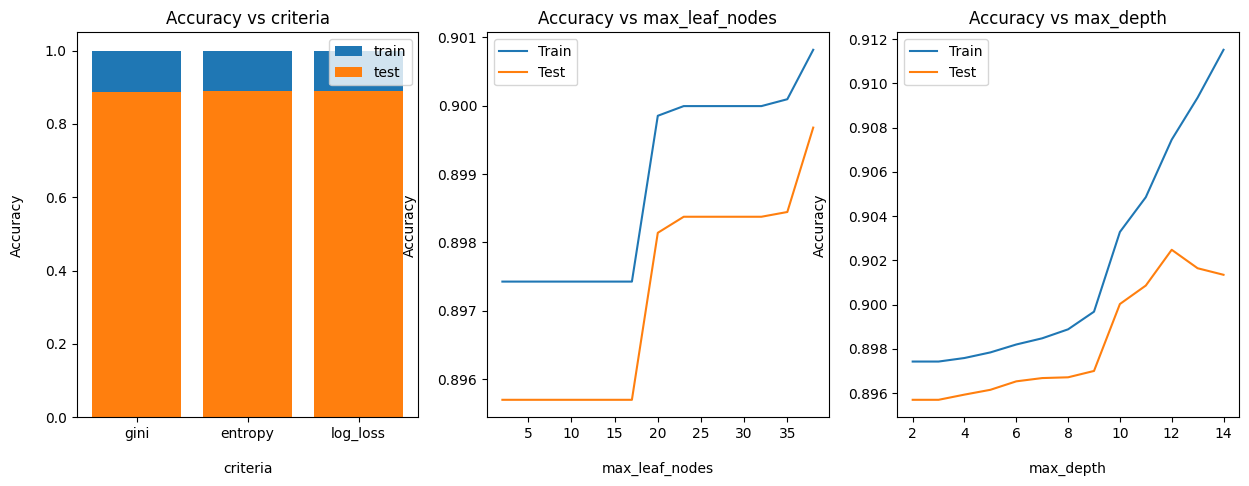

In [12]:
compare_parameters(params, test_acc, train_acc)  

Model: DecisionTreeClassifier(criterion='entropy', max_depth=10, max_leaf_nodes=38)
Score: 0.898


[Text(0.5186567164179104, 0.9545454545454546, 'Vehicle_Age <= 1.5\nentropy = 1.0\nsamples = 268338\nvalue = [134087, 134251]'),
 Text(0.1865671641791045, 0.8636363636363636, 'Vehicle_Damage <= 0.5\nentropy = 0.619\nsamples = 153767\nvalue = [130165, 23602]'),
 Text(0.35261194029850745, 0.9090909090909092, 'True  '),
 Text(0.05970149253731343, 0.7727272727272727, 'Previously_Insured <= 0.5\nentropy = 0.038\nsamples = 83222\nvalue = [82887, 335]'),
 Text(0.029850746268656716, 0.6818181818181818, 'entropy = 0.23\nsamples = 8307\nvalue = [7996, 311]'),
 Text(0.08955223880597014, 0.6818181818181818, 'entropy = 0.004\nsamples = 74915\nvalue = [74891.0, 24.0]'),
 Text(0.31343283582089554, 0.7727272727272727, 'Age <= 0.115\nentropy = 0.915\nsamples = 70545\nvalue = [47278, 23267]'),
 Text(0.14925373134328357, 0.6818181818181818, 'Policy_Sales_Channel <= 0.923\nentropy = 0.546\nsamples = 14811\nvalue = [12949.0, 1862.0]'),
 Text(0.08955223880597014, 0.5909090909090909, 'Age <= 0.069\nentropy = 

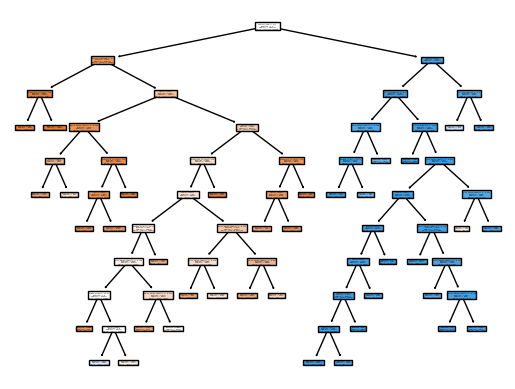

In [ ]:
model, class_score = create_best_model(best_parameters_class)
tree.plot_tree(model, filled=True, feature_names=list(x_test_class.columns))

# Регрессия

In [ ]:
# Инициализация словарей для хранения метрик качества модели регрессии:
# train_acc - для хранения результатов на тренировочной выборке (R² score)
# test_acc - для хранения результатов на тестовой выборке (R² score)
# cross_val_acc - для хранения результатов кросс-валидации
train_acc = {}
test_acc = {}
cross_val_acc = {}

# Словарь для сохранения оптимальных параметров модели регрессии
best_parameters_reg = dict()

# Определение сетки параметров для настройки регрессионной модели:
# criterion - критерии качества для регрессии:
#   ["poisson", "friedman_mse", "absolute_error", "squared_error"]
# max_leaf_nodes - максимальное количество листьев (от 2 до 40 с шагом 3)
# max_depth - максимальная глубина дерева (от 2 до 15)
params = {
    "criterion": ["poisson", "friedman_mse", "absolute_error", "squared_error"],
    "max_leaf_nodes": range(2, 40, 3),
    "max_depth": range(2, 15)
}

# Поиск оптимального критерия качества для регрессии:
# Передаем флаг is_regression=True, так как это задача регрессии
# Тестируем все критерии из params["criterion"]
# Используем регрессионные данные (x_train_reg, y_train_reg и т.д.)
best_parameters_reg["criterion"] = test_parameters(
    {"criterion": params["criterion"]}, 
    train_acc, test_acc, cross_val_acc,
    x_train_reg, y_train_reg, 
    x_test_reg, y_test_reg, 
    is_regression=True
)

# Поиск оптимального количества листьев для регрессии:
# Тестируем значения max_leaf_nodes от 2 до 40 с шагом 3
best_parameters_reg["max_leaf_nodes"] = test_parameters(
    {"max_leaf_nodes": params["max_leaf_nodes"]},
    train_acc, test_acc, cross_val_acc,
    x_train_reg, y_train_reg,
    x_test_reg, y_test_reg,
    is_regression=True
)

# Поиск оптимальной глубины дерева для регрессии:
# Тестируем значения max_depth от 2 до 15
best_parameters_reg["max_depth"] = test_parameters(
    {"max_depth": params["max_depth"]},
    train_acc, test_acc, cross_val_acc,
    x_train_reg, y_train_reg,
    x_test_reg, y_test_reg,
    is_regression=True
)

# Визуальное сравнение влияния параметров на качество модели:
# compare_parameters строит графики для всех тестируемых параметров
# is_regression=True указывает, что это задача регрессии (используются R² метрики)
compare_parameters(
    params, 
    test_acc, 
    train_acc, 
    is_regression=True
)

Model: DecisionTreeRegressor(criterion='friedman_mse', max_depth=14, max_leaf_nodes=17)
Score: 0.845


[Text(0.4027777777777778, 0.9285714285714286, 'Общая.площадь <= 0.361\nfriedman_mse = 1290199147076.002\nsamples = 565\nvalue = 2751369.731'),
 Text(0.14814814814814814, 0.7857142857142857, 'Общая.площадь <= 0.21\nfriedman_mse = 336810582897.862\nsamples = 302\nvalue = 1954483.437'),
 Text(0.27546296296296297, 0.8571428571428572, 'True  '),
 Text(0.07407407407407407, 0.6428571428571429, 'Общая.площадь <= 0.105\nfriedman_mse = 174938330099.68\nsamples = 106\nvalue = 1349009.434'),
 Text(0.037037037037037035, 0.5, 'friedman_mse = 21455547666.009\nsamples = 39\nvalue = 868205.128'),
 Text(0.1111111111111111, 0.5, 'friedman_mse = 51387926041.435\nsamples = 67\nvalue = 1628880.597'),
 Text(0.2222222222222222, 0.6428571428571429, 'Общая.площадь <= 0.266\nfriedman_mse = 118867490130.061\nsamples = 196\nvalue = 2281933.663'),
 Text(0.18518518518518517, 0.5, 'friedman_mse = 56984917091.836\nsamples = 56\nvalue = 1964107.143'),
 Text(0.25925925925925924, 0.5, 'Общая.площадь <= 0.332\nfriedman_ms

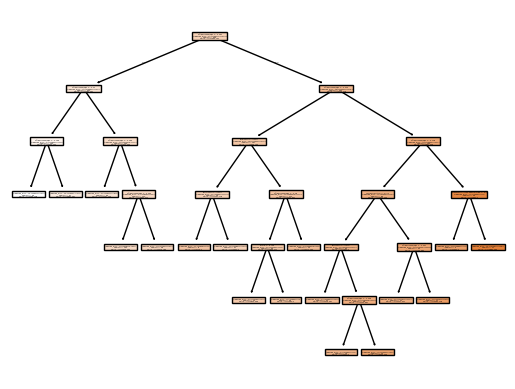

In [17]:
model, regr_score = create_best_model(best_parameters_reg, is_regression=True)
tree.plot_tree(model, filled=True, feature_names=list(x_test_reg.columns))

# Обрезка дерева

# Классификация

In [ ]:
# Создаем базовое дерево решений для классификации с параметрами:
# criterion="entropy" - используем энтропийный критерий для разделения
# max_depth=5 - ограничиваем максимальную глубину дерева до 5 уровней
dtc = DecisionTreeClassifier(criterion="entropy", max_depth=5)

# Вычисляем путь cost-complexity pruning (CCP) для дерева:
# Этот метод помогает найти оптимальные значения параметра ccp_alpha
# x_train_class, y_train_class - обучающие данные для задачи классификации
path = dtc.cost_complexity_pruning_path(x_train_class, y_train_class)

# Извлекаем вычисленные значения ccp_alpha из пути обрезки
# ccp_alphas - массив эффективных альфа-значений для обрезки
ccp_alphas = path.ccp_alphas

# Создаем словарь параметров для тестирования:
# Включаем только что полученные значения ccp_alpha
params = {
    "ccp_alpha": path.ccp_alphas
}

# Тестируем различные значения ccp_alpha для поиска оптимального:
# Используем ранее определенную функцию test_parameters
# Передаем словарь с параметрами и данные классификации
# Функция вернет лучшее значение ccp_alpha и сохранит метрики в train_acc, test_acc
best_cpp = test_parameters(
    params, 
    train_acc, 
    test_acc, 
    cross_val_acc, 
    x_train_class, 
    y_train_class, 
    x_test_class, 
    y_test_class
)

The best model: DecisionTreeClassifier(ccp_alpha=np.float64(2.3769082430077394e-05))
Accuracy: 0.972


Model: DecisionTreeClassifier(ccp_alpha=np.float64(2.3769082430077394e-05),
                       criterion='entropy', max_depth=10, max_leaf_nodes=38)
Score: 0.898


[Text(0.5186567164179104, 0.9545454545454546, 'Vehicle_Age <= 1.5\nentropy = 1.0\nsamples = 268338\nvalue = [134087, 134251]'),
 Text(0.1865671641791045, 0.8636363636363636, 'Vehicle_Damage <= 0.5\nentropy = 0.619\nsamples = 153767\nvalue = [130165, 23602]'),
 Text(0.35261194029850745, 0.9090909090909092, 'True  '),
 Text(0.05970149253731343, 0.7727272727272727, 'Previously_Insured <= 0.5\nentropy = 0.038\nsamples = 83222\nvalue = [82887, 335]'),
 Text(0.029850746268656716, 0.6818181818181818, 'entropy = 0.23\nsamples = 8307\nvalue = [7996, 311]'),
 Text(0.08955223880597014, 0.6818181818181818, 'entropy = 0.004\nsamples = 74915\nvalue = [74891.0, 24.0]'),
 Text(0.31343283582089554, 0.7727272727272727, 'Age <= 0.115\nentropy = 0.915\nsamples = 70545\nvalue = [47278, 23267]'),
 Text(0.14925373134328357, 0.6818181818181818, 'Policy_Sales_Channel <= 0.923\nentropy = 0.546\nsamples = 14811\nvalue = [12949.0, 1862.0]'),
 Text(0.08955223880597014, 0.5909090909090909, 'Age <= 0.069\nentropy = 

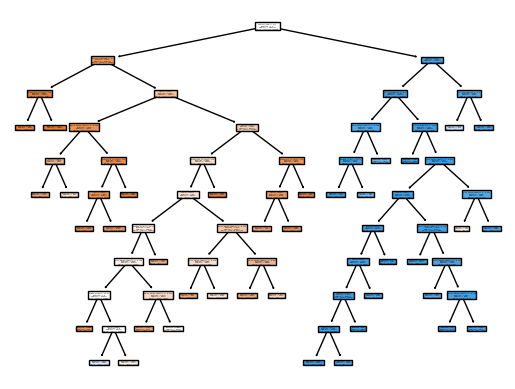

In [ ]:
# Добавляем найденное оптимальное значение ccp_alpha в словарь лучших параметров для классификации
best_parameters_class["ccp_alpha"] = best_cpp

# Создаем и обучаем модель дерева решений с оптимальными параметрами:
# - Используем функцию create_best_model
# - Передаем словарь best_parameters_class со всеми подобранными параметрами
# - Функция возвращает обученную модель и оценку её точности
model, score_a_c = create_best_model(best_parameters_class)

# Визуализируем построенное дерево решений:
# - filled=True - заливаем узлы цветами для лучшей читаемости
# - feature_names - используем имена признаков из обучающей выборки
# - plot_tree из sklearn.tree отрисовывает структуру дерева
tree.plot_tree(model, filled=True, feature_names=list(x_train_class.columns))

регрессия

In [ ]:
# Создаем базовую модель дерева решений для регрессии с ограничением глубины
# max_depth=5 - ограничиваем максимальную глубину дерева 5 уровнями
# Это поможет избежать переобучения на начальном этапе
dtr = DecisionTreeRegressor(max_depth=5)
+
# Вычисляем путь cost-complexity pruning для регрессионного дерева
# Метод находит эффективные значения alpha для пост-обрезки дерева
# x_train_reg, y_train_reg - обучающие данные для задачи регрессии
path = dtr.cost_complexity_pruning_path(x_train_reg, y_train_reg)

# Подготавливаем параметры для тестирования:
# Используем найденные значения ccp_alpha для поиска оптимального
params = {
    "ccp_alpha": path.ccp_alphas
}

# Тестируем различные значения ccp_alpha для регрессионной модели:
# is_regression=True указывает, что это задача регрессии
# Функция вернет оптимальное значение alpha и сохранит метрики
best_cpp = test_parameters(
    params, 
    train_acc, 
    test_acc, 
    cross_val_acc, 
    x_train_reg, 
    y_train_reg, 
    x_test_reg, 
    y_test_reg, 
    is_regression=True
)

# Добавляем найденное оптимальное значение alpha в словарь параметров
best_parameters_reg["ccp_alpha"] = best_cpp

# Создаем итоговую модель регрессии со всеми оптимальными параметрами:
# is_regression=True указывает на создание DecisionTreeRegressor
# Возвращаем модель, но не используем score (_ - игнорируем второе возвращаемое значение)
model, _ = create_best_model(best_parameters_reg, is_regression=True)

# Визуализируем структуру итогового регрессионного дерева:
# filled=True - цветовая заливка узлов по значению
# feature_names - подписываем признаки их именами из тестовой выборки
tree.plot_tree(model, filled=True, feature_names=list(x_test_reg.columns))

The best model: DecisionTreeRegressor(ccp_alpha=np.float64(3404583275.7127094))
Accuracy: 0.842


видим, что обрезка дерева приводит к увеличению точности и скора

In [ ]:
# Создаем DataFrame для сравнения моделей классификации:
# "Model name" - названия алгоритмов машинного обучения
# "Score" - метрики accuracy (точность) для каждой модели
class_models = pd.DataFrame(
    {
        "Model name": ["Логистическая регрессия", "Метод Ближайших Соседей", 
                     "Наивный Байесовский Классификатор", "Линейный Дискриминантный Анализ",
                     "Квадратичный Дискриминантный Анализ", "Машина Опорных Векторов"],
        "Score": [0.811, 0.768, 0.812, 0.812, 0.814, 0.876],
    }
)

# Создаем DataFrame для сравнения моделей регрессии:
# "Model name" - названия регрессионных алгоритмов
# "R^2" - коэффициент детерминации для каждой модели
regression_models = pd.DataFrame(
    {
        "Model name": ["Линейная регрессия", "Лассо регрессия", "Гребневая регрессия", 
                     "Elastic-Net", "Метод наименьших углов", "Байесовская регрессия",
                     "Обобщённая линейная регрессия", "Взвешенный МНК", 
                     "Полиномиальная регрессия", "Непараметрическая регрессия", 
                     "Сплайновая регрессия"],
        "R^2": [0.897, 0.898, 0.898, 0.888, 0.897, 0.898, 
               0.880, 0.878, 0.892, 0.696, 0.880],
    }
)

In [24]:
class_models.loc[len(class_models.index)] = ["Деревья решений", round(class_score, 3)]
print(class_models)


                            Model name  Score
0              Логистическая регрессия  0.811
1              Метод Ближайших Соседей  0.768
2    Наивный Байесовский Классификатор  0.812
3      Линейный Дискриминантный Анализ  0.812
4  Квадратичный Дискриминантный Анализ  0.814
5              Машина Опорных Векторов  0.876
6                      Деревья решений  0.898


In [25]:
regression_models.loc[len(regression_models.index)] = ["Деревья решений", round(regr_score, 3)]
print(regression_models)

                       Model name    R^2
0              Линейная регрессия  0.897
1                 Лассо регрессия  0.898
2             Гребневая регрессия  0.898
3                     Elastic-Net  0.888
4          Метод наименьших углов  0.897
5           Байесовская регрессия  0.898
6   Обобщённая линейная регрессия  0.880
7                  Взвешенный МНК  0.878
8        Полиномиальная регрессия  0.892
9     Непараметрическая регрессия  0.696
10           Сплайновая регрессия  0.880
11                Деревья решений  0.845


In [ ]:
def plot_bar_graph(ax, names, scoring, title):
    """
    Функция для построения столбчатой диаграммы метрик моделей.
    
    Параметры:
        ax (matplotlib.axes): Область для построения графика
        names (list): Список названий моделей
        scoring (list): Список значений метрик
        title (str): Заголовок графика
    """
    # Создаем столбчатую диаграмму
    ax.bar(names, scoring)
    
    # Устанавливаем заголовок
    ax.set_title(title)
    
    # Поворачиваем подписи по оси X на 90 градусов для лучшей читаемости
    ax.tick_params(axis="x", labelrotation=90)  
    
    # Устанавливаем пределы оси Y (от 0.5 до 1)
    ax.set_ylim((0.5, 1))
    
    # Добавляем текстовые метки с значениями над каждым столбцом
    for rect, score in zip(ax.patches, scoring):
        ax.text(rect.get_x() + rect.get_width() / 2,  # Позиция по X (центр столбца)
               rect.get_height() + 0.01,             # Позиция по Y (выше столбца)
               score,                               # Текст (значение метрики)
               ha="center")                         # Горизонтальное выравнивание по центру
    
    # Подписываем оси
    ax.set_xlabel("Модель", labelpad=15)
    ax.set_ylabel("Score", labelpad=15)

def compare_models():
    """
    Функция для сравнения моделей классификации и регрессии на одном изображении.
    Создает два графика рядом: для регрессионных и классификационных моделей.
    """
    # Создаем фигуру с двумя областями для графиков (1 строка, 2 столбца)
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25, 7))
    
    # Регулируем расстояние между графиками
    fig.subplots_adjust(hspace=0.4)
    
    # Строим график для регрессионных моделей (левый график)
    plot_bar_graph(axs[0], 
                  regression_models["Model name"],  # Названия моделей
                  regression_models["R^2"],        # Значения R^2
                  "Регрессии")                      # Заголовок
    
    # Строим график для классификационных моделей (правый график)
    plot_bar_graph(axs[1],
                  class_models["Model name"],       # Названия моделей
                  class_models["Score"],           # Значения Accuracy
                  "Классификации")                 # Заголовок

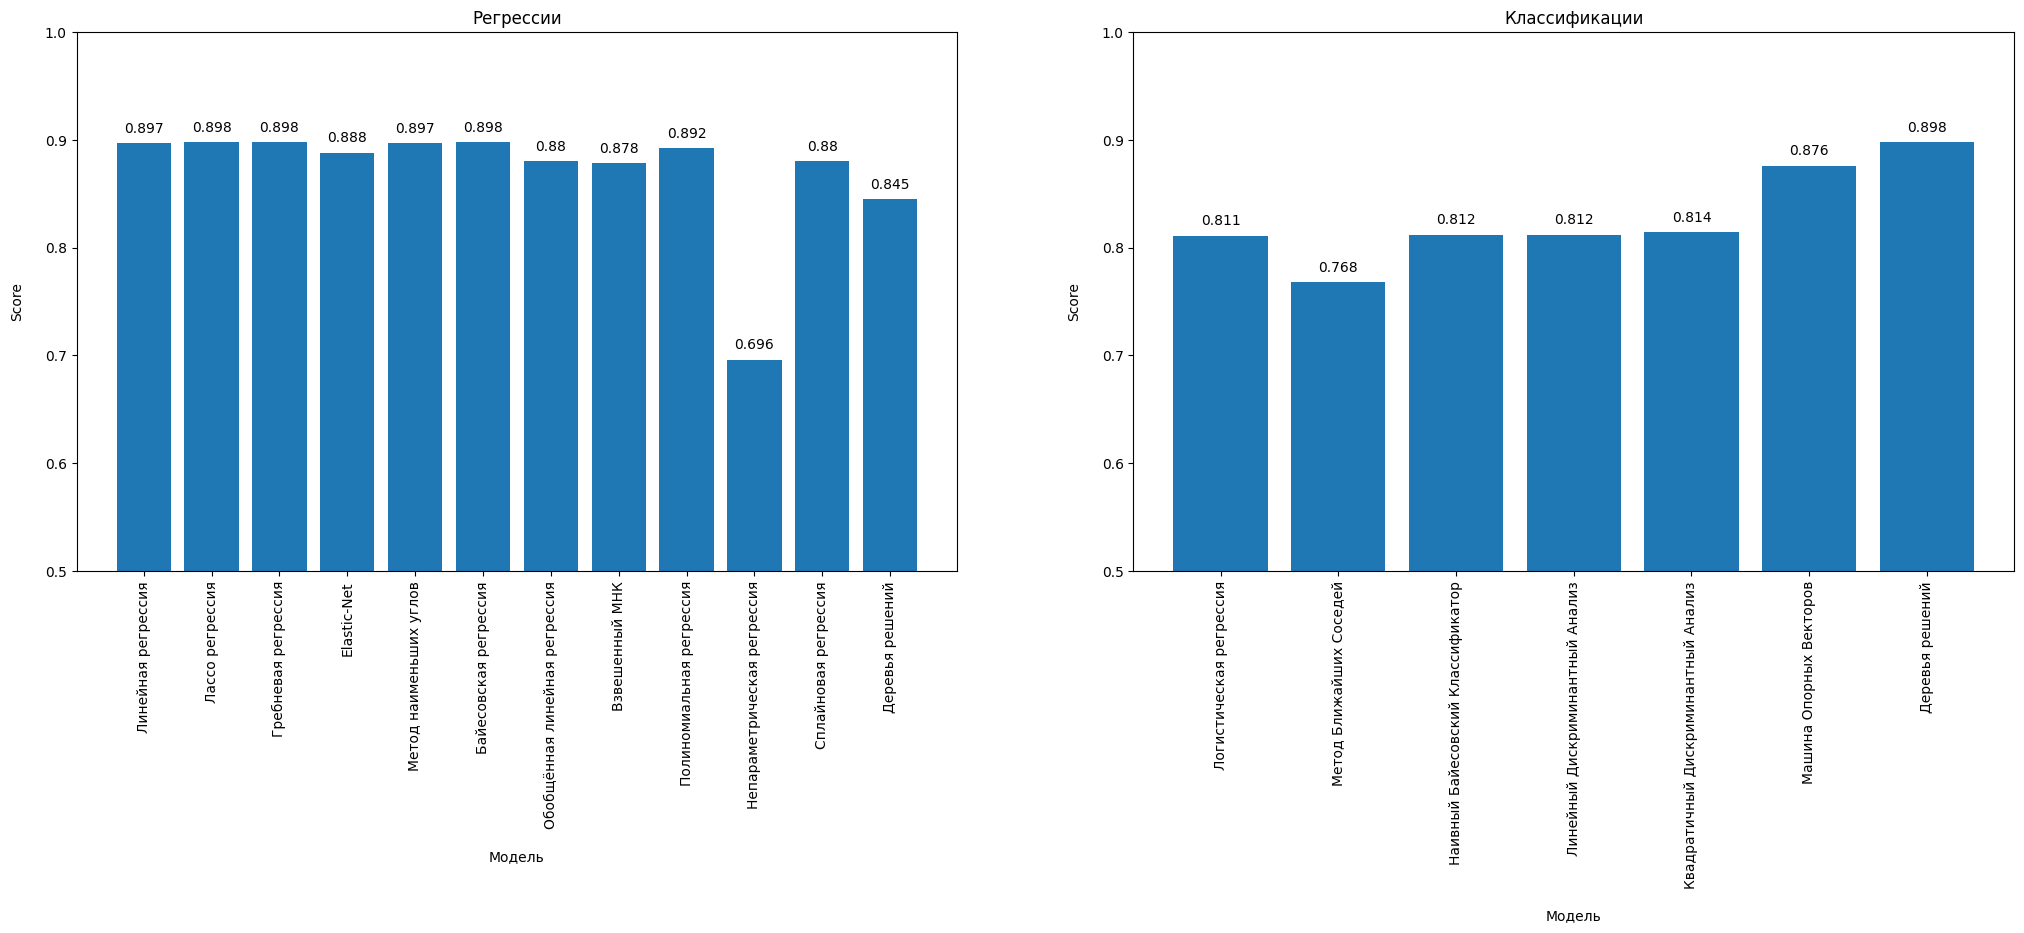

In [27]:
compare_models()